# Notebook 002: Exploring Sentinel-2 Data with Open Data Cube

## Introduction

In this notebook, we will explore Sentinel-2 Analysis Ready Data using the Open Data Cube (ODC). We will:

- Install necessary packages.
- Initialize the data cube.
- Explore product measurements and flags.
- Define an area of interest and visualize it on an interactive map.
- Query datasets within a specific time range.
- Load and process the data.
- Visualize the data over time.

This tutorial is designed to help you understand how to work with satellite imagery data in Python using ODC.

---

## 1. Install Necessary Packages

First, we need to install the required packages. We use `!` to run shell commands directly from the notebook.

In [ ]:
!pip install --upgrade pip setuptools wheel
!pip install hdstats deafrica-tools

## 2. Import Libraries

Import the necessary libraries for working with the data cube and data manipulation.

In [1]:
import datacube
from datacube.utils import geometry
import pandas as pd

---

## 3. Initialize the Data Cube

Create an instance of the data cube with a specific application name. This helps in tracking and managing the applications accessing the data cube.

In [2]:
dc = datacube.Datacube(app="02_Products_and_Measurements_Week_1")

## 4. List Measurements for the Product

We will work with the Sentinel-2 Analysis Ready Data product, `s2_ard_scene`. Let's list the measurements available in this product.

In [3]:
product = "s2_ard_scene"
measurements = dc.list_measurements()
measurements.loc[product]

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
B01_60m,B01_60m,int16,reflectance,-9999,"[band_1, coastal_aerosol]",NaN
B02_10m,B02_10m,int16,reflectance,-9999,"[band_2, blue]",NaN
B03_10m,B03_10m,int16,reflectance,-9999,"[band_3, green]",NaN
B04_10m,B04_10m,int16,reflectance,-9999,"[band_4, red]",NaN
B05_20m,B05_20m,int16,reflectance,-9999,"[band_5, veg5]",NaN
B06_20m,B06_20m,int16,reflectance,-9999,"[band_6, veg6]",NaN
B07_20m,B07_20m,int16,reflectance,-9999,"[band_7, veg7]",NaN
B08_10m,B08_10m,int16,reflectance,-9999,"[band_8, nir]",NaN
B8A_20m,B8A_20m,int16,reflectance,-9999,"[band_8a, narrow_nir]",NaN


This will display a table of measurements for the selected product.

---

## 5. Explore SLC Flags

The `SLC_20m` measurement contains scene classification (SLC) flags that can be used for masking clouds, shadows, and other features. Let's extract and print the flag definitions.

In [4]:
# Extract the row corresponding to 'SLC_20m'
slc_flags = measurements.loc[product].loc['SLC_20m', 'flags_definition']

# Print the list of flag definitions
print(slc_flags)

{'slc': {'bits': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'values': {'1': 'Saturated or defective pixel', '2': 'Dark features / Shadows', '3': 'Cloud shadows', '4': 'Vegetation', '5': 'Not vegetated', '6': 'Water', '7': 'Unclassified', '8': 'Cloud medium probability', '9': 'cloud high probability', '10': 'Thin cirrus', '11': 'Snow or ice'}, 'description': 'Scene classification'}}


## Explanation of SLC Flags

When working with satellite imagery, it's important to understand and manage various factors that can affect the quality and usability of the data. One such factor is the presence of clouds, shadows, water bodies, and other surface features that can obscure or alter the true reflectance values captured by the satellite sensors. To address this, Sentinel-2 provides **Scene Classification (SLC) flags** that help identify and categorize different types of pixels within an image.

### Understanding the SLC Flags Dictionary

The SLC flags are represented as a dictionary in Python, which provides detailed information about each classification category. Here's a breakdown of the dictionary:

```python
{
    'slc': {
        'bits': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
        'values': {
            '1': 'Saturated or defective pixel',
            '2': 'Dark features / Shadows',
            '3': 'Cloud shadows',
            '4': 'Vegetation',
            '5': 'Not vegetated',
            '6': 'Water',
            '7': 'Unclassified',
            '8': 'Cloud medium probability',
            '9': 'cloud high probability',
            '10': 'Thin cirrus',
            '11': 'Snow or ice'
        },
        'description': 'Scene classification'
    }
}
```

#### Components of the Dictionary

1. **`bits`**:
  
  - Represents the individual bits assigned to each classification category.
  - Each bit corresponds to a specific type of feature or condition detected in the scene.
2. **`values`**:
  
  - Maps each bit to its corresponding description.
  - Provides a human-readable explanation of what each bit signifies.
3. **`description`**:
  
  - A brief description of the classification system, in this case, "Scene classification."

#### Detailed Breakdown of Each SLC Flag

| **Bit** | **Value** | **Description** |
| --- | --- | --- |
| 1   | Saturated or defective pixel | Pixels that are overexposed or have defects. These pixels may not provide reliable reflectance values. |
| 2   | Dark features / Shadows | Areas with low reflectance, such as shadows or dark surface features. |
| 3   | Cloud shadows | Shadows cast by clouds, which can affect the brightness and visibility of underlying features. |
| 4   | Vegetation | Areas covered by healthy vegetation, indicating active plant growth. |
| 5   | Not vegetated | Surfaces without significant vegetation, such as bare soil or urban areas. |
| 6   | Water | Water bodies, including rivers, lakes, and coastal areas. |
| 7   | Unclassified | Pixels that do not fall into any of the predefined categories. |
| 8   | Cloud medium probability | Areas with a medium likelihood of being covered by clouds. |
| 9   | Cloud high probability | Areas with a high likelihood of cloud cover, which can obscure the surface features. |
| 10  | Thin cirrus | Thin, wispy clouds that may allow some surface details to be visible. |
| 11  | Snow or ice | Regions covered by snow or ice, which can reflect sunlight differently compared to other surfaces. |

###

In [5]:
x = (-61.25, -61.31)
y = (10.6, 10.66)

In [6]:
import matplotlib.pyplot as plt
import datacube
import odc.algo
from datetime import datetime, timedelta
import numpy as np

### Analyze and Visualize Data Over Time

In this section, we will process and visualize Sentinel-2 datasets for the year 2022. The steps include defining the temporal range, specifying the bands to use, initializing data structures to store images by month, iterating through each day of the year to load and process available datasets, and finally visualizing the processed images.

---

#### **Define the Time Range and Bands**

First, we define the start and end dates for the year 2022 and specify the spectral bands we will use for creating RGB composites.

In [7]:
# Define the time range for the year 2022
start_date = datetime(2022, 1, 1)
end_date = datetime(2022, 12, 31)
days_range = (start_date, end_date)

# Bands to use for RGB composite
bands = ['red', 'green', 'blue']

**Explanation:**

- **`start_date` and `end_date`**: These variables set the temporal boundaries for our analysis, covering the entire year of 2022.
- **`bands`**: We select the 'red', 'green', and 'blue' bands to create RGB composite images, which are essential for visual interpretation of the satellite data.

---

#### **Initialize Data Structures**

We create a dictionary to organize images by month and define a helper function to extract the month and day from a given date.

In [8]:
# Initialize a dictionary to store images by month
images_by_month = {month: [] for month in range(1, 13)}

# Function to extract month and day from a datetime object
def date_to_index(date):
    month = date.month
    day = date.day
    return month, day

**Explanation:**

- **`images_by_month`**: This dictionary will hold lists of images for each month (January to December). Each key represents a month number (1 to 12), and the corresponding value is an empty list that will later store image data and related statistics.
- **`date_to_index`**: A utility function that takes a `datetime` object and returns its month and day. This helps in indexing and organizing images based on their acquisition dates.

---

#### **Retrieve Datasets Within the Time Range**

We fetch all available datasets for the specified product within the defined time range.

In [9]:
# Initialize the current date to start_date
current_date = start_date

# Find all datasets within the specified time range
datasets_in_range = dc.find_datasets(product='s2_ard_scene', time=days_range)

**Explanation:**

- **`current_date`**: A variable to keep track of the date as we iterate through each day of the year.
- **`datasets_in_range`**: Retrieves all Sentinel-2 Analysis Ready Data (`s2_ard_scene`) datasets that fall within the `days_range`. This optimizes our search by limiting the datasets to the year 2022.

---

#### **Iterate Over Each Day to Process Datasets**

We loop through each day of the year, check for available datasets, load the data, apply masking to filter out unwanted pixels, and store the processed images along with relevant statistics.

In [10]:
# Iterate over each day in the year
while current_date <= end_date:
    # Check if there is a dataset available for the current date
    for ds in datasets_in_range:
        if ds.time.begin.date() == current_date.date():

            # Load the dataset using datacube
            rgb_image = dc.load(
                product='s2_ard_scene',
                measurements=bands + ['slc'],  # Add 'slc' band for masking
                output_crs='EPSG:32620',       # Set CRS to UTM zone 20N
                resolution=(100, -100),        # Set resolution for small images
                x=(-61.25, -61.31),            # Longitude range
                y=(10.6, 10.66),               # Latitude range
                datasets=[ds]                  # Load the individual dataset
            )

            # Create a mask using the 'slc' band and specified categories
            mask = odc.algo.enum_to_bool(
                rgb_image['slc'], 
                categories=[ 
                    'Cloud shadows',  
                    'Saturated or defective pixel', 
                    'Thin cirrus', 
                    'Dark features / Shadows', 
                    #'Cloud medium probability', 
                    'cloud high probability', 
                    'Unclassified',  
                ] 
            )

            # Apply the mask to the color bands (red, green, blue)
            valid_rgb = odc.algo.erase_bad(rgb_image[bands], where=mask)

            # Select the first image (if multiple images per date)
            rgb_array = valid_rgb.isel(time=0).to_array().values

            # Normalize pixel values for proper display with imshow
            rgb_array = np.clip(rgb_array / np.max(rgb_array), 0, 1)

            # Calculate the percentage of valid pixels
            total_pixels = np.prod(mask.shape)
            valid_pixels = np.sum(~mask.isel(time=0).values)
            valid_percentage = (valid_pixels / total_pixels) * 100

            # Extract month and day from the current date
            month, day = date_to_index(current_date)

            # Store the processed image and its statistics in the dictionary
            images_by_month[month].append((day, rgb_array, current_date, valid_percentage, total_pixels))

            break  # Exit the loop if a dataset is found for the current day

    # Move to the next day
    current_date += timedelta(days=1)

In [11]:
print("")

**Explanation:**

1. **Iterating Through Each Day:**
  
  - **`while current_date <= end_date:`**: Ensures the loop runs from January 1, 2022, to December 31, 2022.
2. **Checking for Available Datasets:**
  
  - **`for ds in datasets_in_range:`**: Iterates through all datasets retrieved within the time range.
  - **`if ds.time.begin.date() == current_date.date():`**: Checks if the dataset's acquisition date matches the current date in the loop.
3. **Loading the Dataset:**
  
  - **`dc.load()`**: Loads the specified dataset with the following parameters:
    - **`product='s2_ard_scene'`**: Specifies the Sentinel-2 Analysis Ready Data product.
    - **`measurements=bands + ['slc']`**: Includes the 'red', 'green', 'blue' bands for RGB visualization and the 'slc' band for masking.
    - **`output_crs='EPSG:32620'`**: Sets the Coordinate Reference System to UTM zone 20N.
    - **`resolution=(100, -100)`**: Defines the spatial resolution. Positive for X (longitude) and negative for Y (latitude) to maintain North-up orientation.
    - **`x` and `y`**: Define the spatial extent (longitude and latitude ranges) for Trinidad and Tobago.
    - **`datasets=[ds]`**: Loads the individual dataset corresponding to the current date.
4. **Creating the Mask:**
  
  - **`odc.algo.enum_to_bool()`**: Converts specific SLC (Scene Classification) categories into a boolean mask. Pixels falling into the specified categories are marked as `True` (to be masked out).
  - **`categories`**: Specifies the SLC classes to include in the mask, such as cloud shadows, saturated pixels, thin cirrus, etc.
5. **Applying the Mask:**
  
  - **`odc.algo.erase_bad()`**: Applies the mask to the RGB bands, effectively removing or nullifying unwanted pixels based on the mask.
6. **Processing the RGB Array:**
  
  - **`valid_rgb.isel(time=0).to_array().values`**: Selects the first time slice (if multiple) and converts the DataArray to a NumPy array for further processing.
  - **`np.clip()`**: Normalizes the pixel values to a range between 0 and 1, which is suitable for visualization using `imshow`.
7. **Calculating Pixel Statistics:**
  
  - **`total_pixels`**: Total number of pixels in the mask.
  - **`valid_pixels`**: Number of pixels that are not masked out (`~mask`).
  - **`valid_percentage`**: Percentage of valid (unmasked) pixels.
 
8. **Storing the Processed Data:**
  
  - **`images_by_month[month].append(...)`**: Adds a tuple containing the day, RGB array, date, valid pixel percentage, zero pixel count, and total pixels to the corresponding month's list in the `images_by_month` dictionary.
9. **Advancing the Date:**
  
  - **`current_date += timedelta(days=1)`**: Moves to the next day in the loop.

---

#### **Visualize the Processed Images**

After processing all available datasets, we generate plots for each month that contains images. Each plot displays the RGB composite images along with relevant statistics.

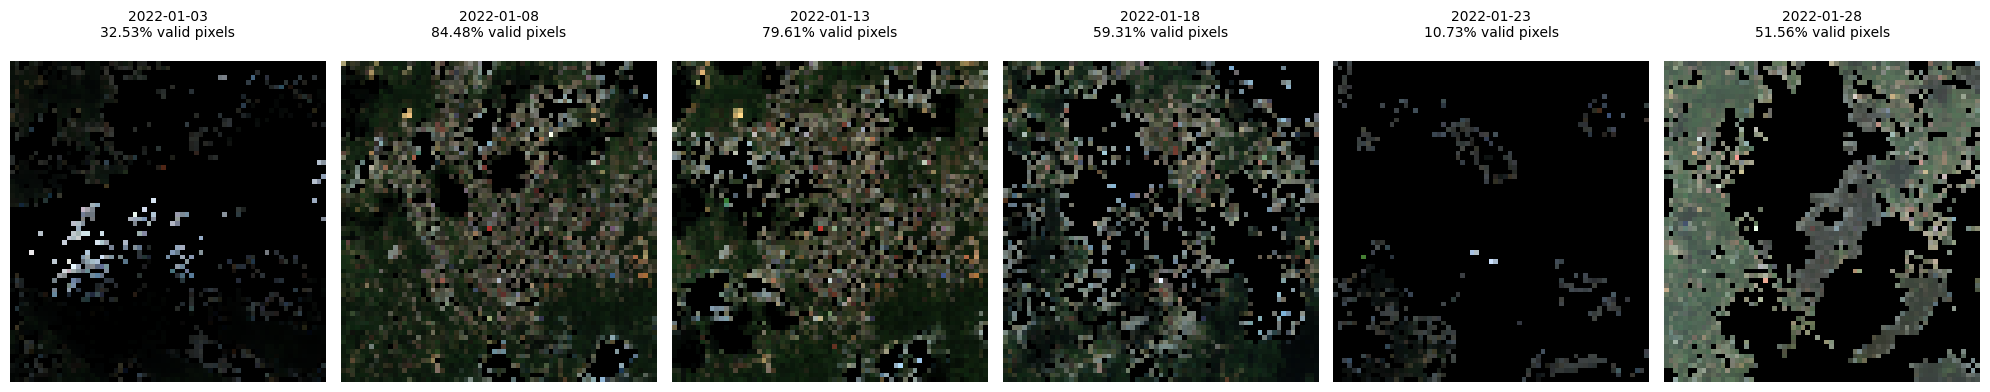

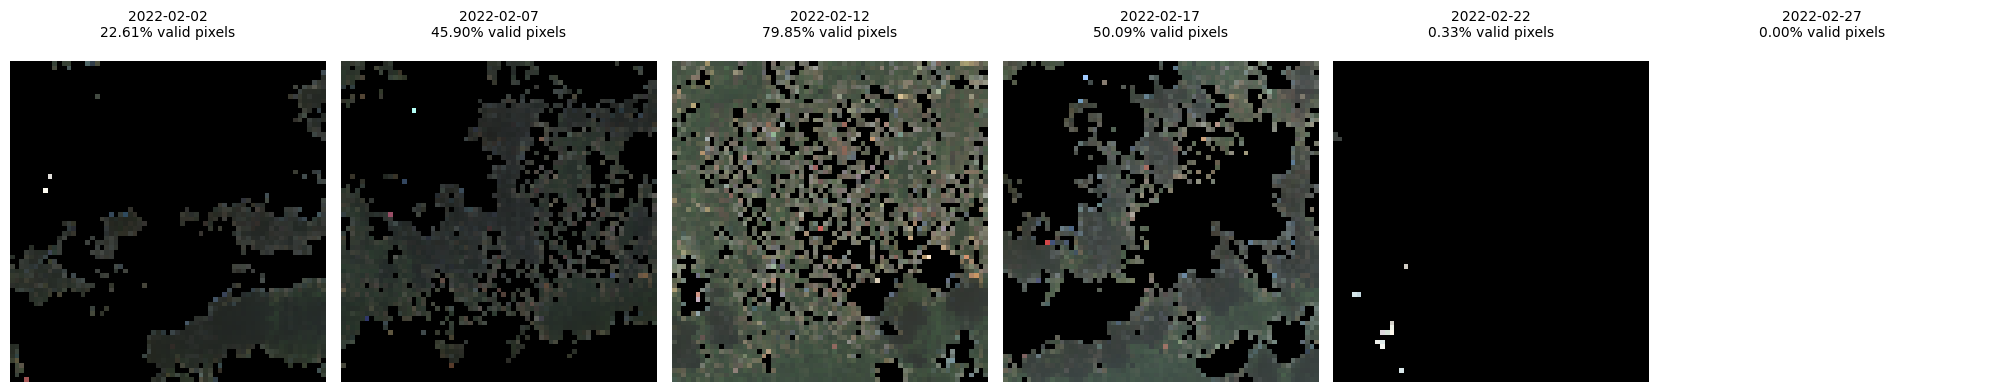

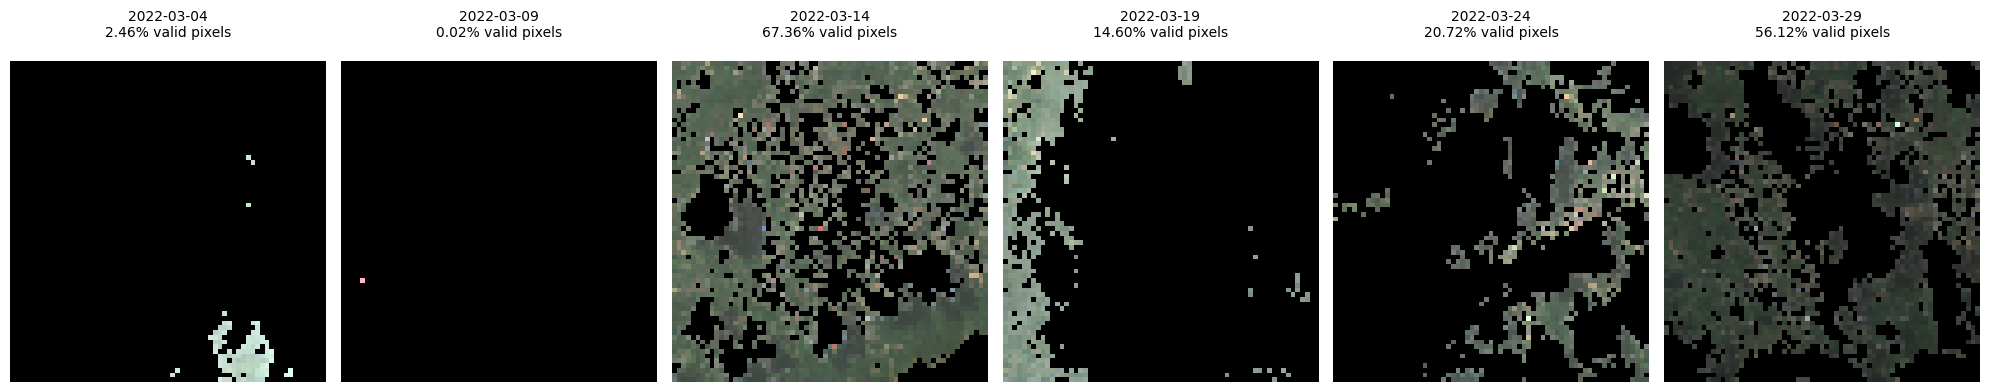

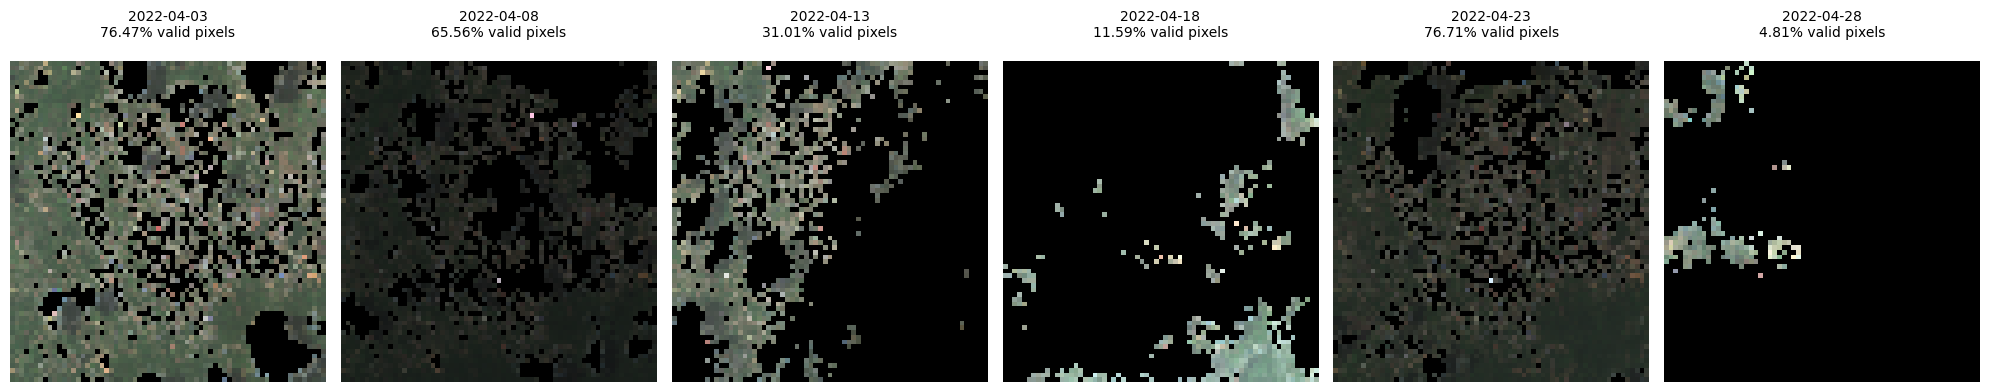

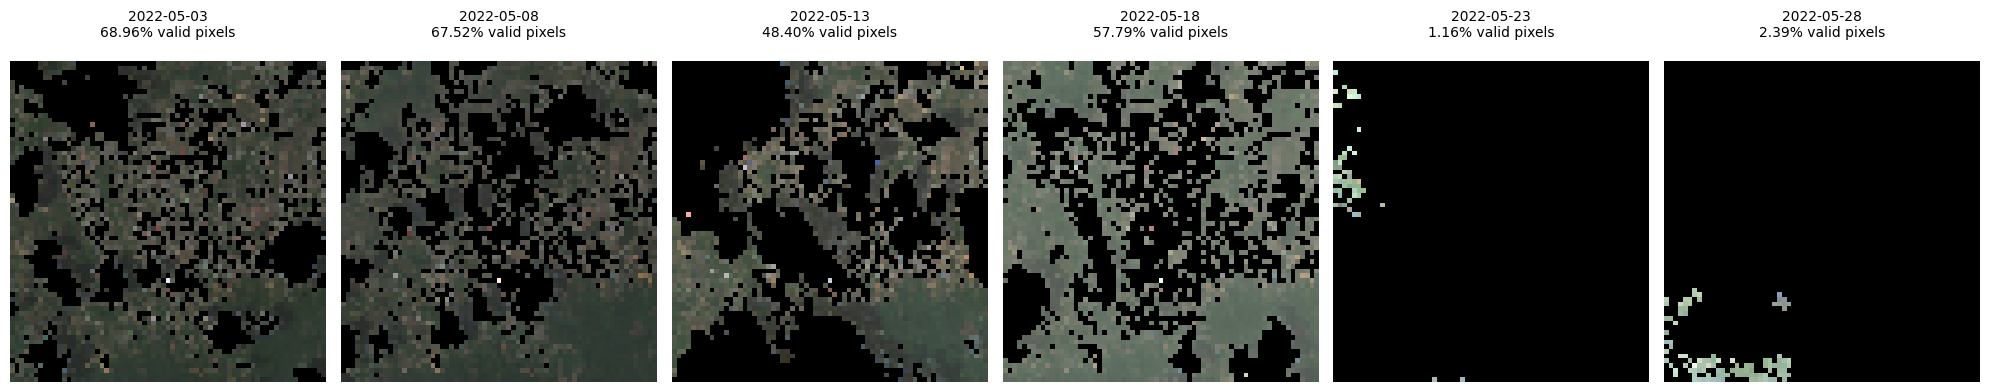

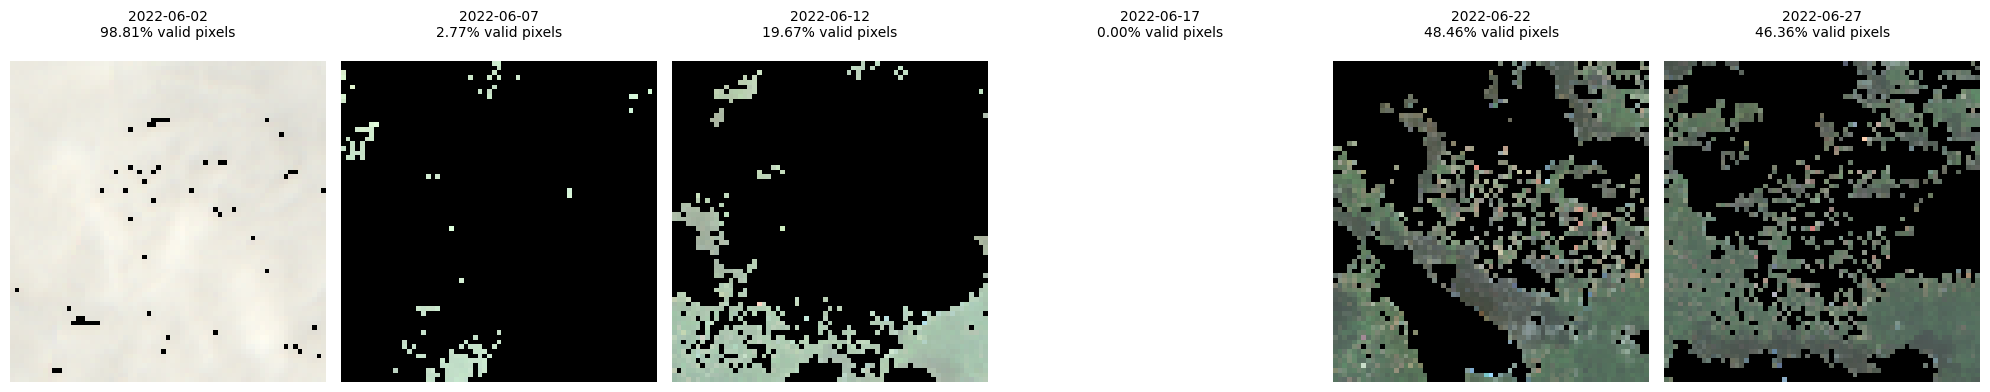

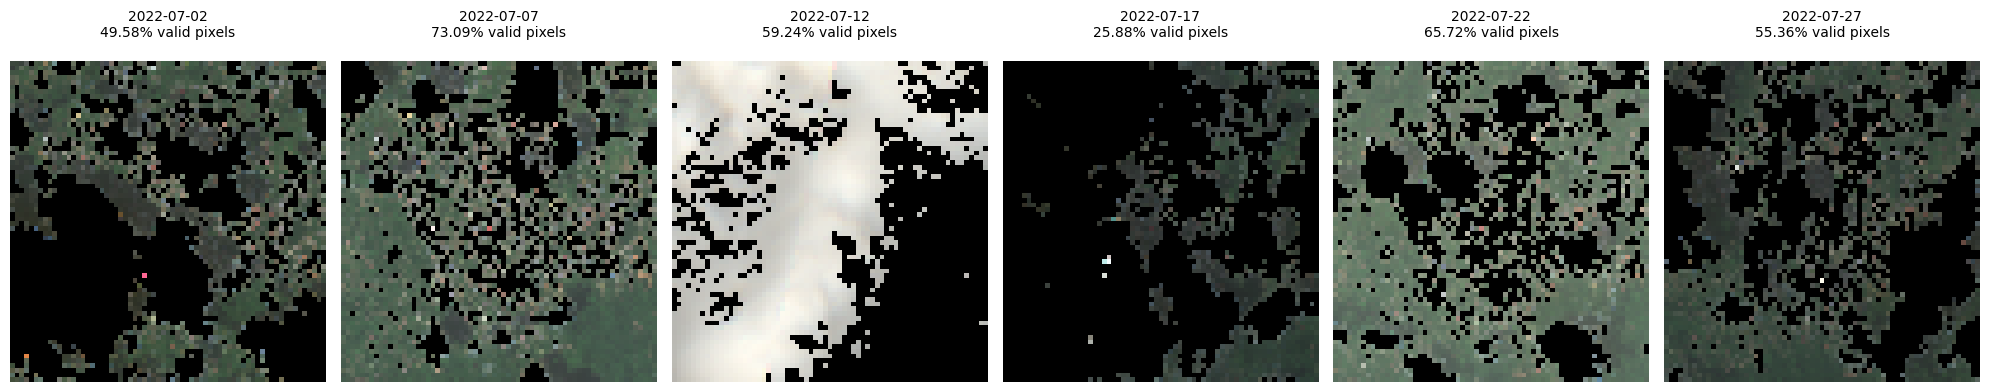

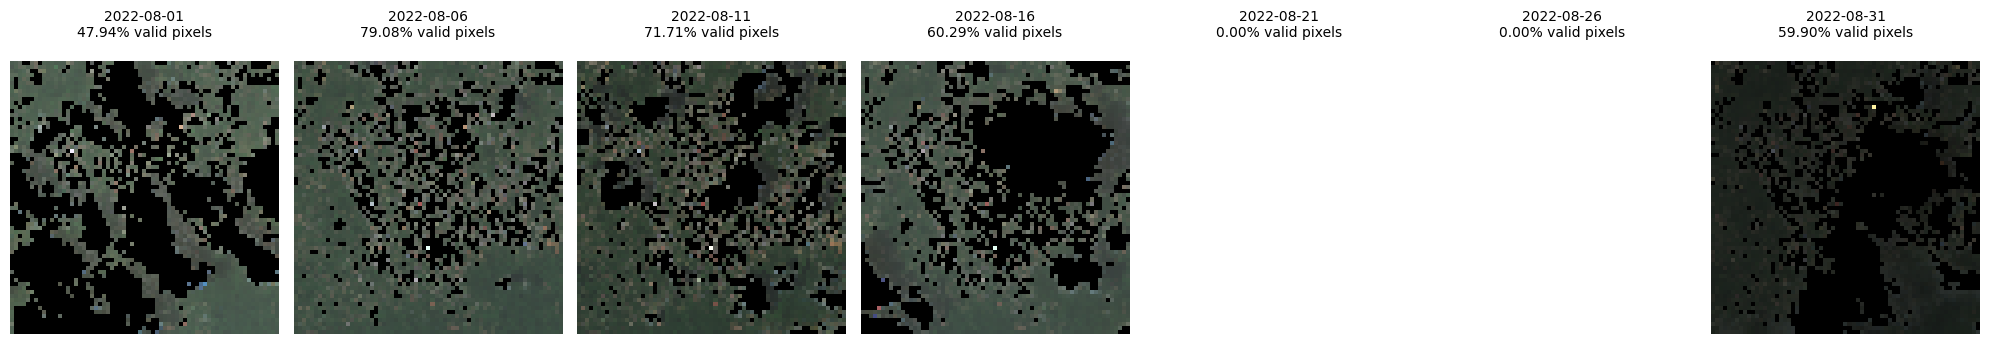

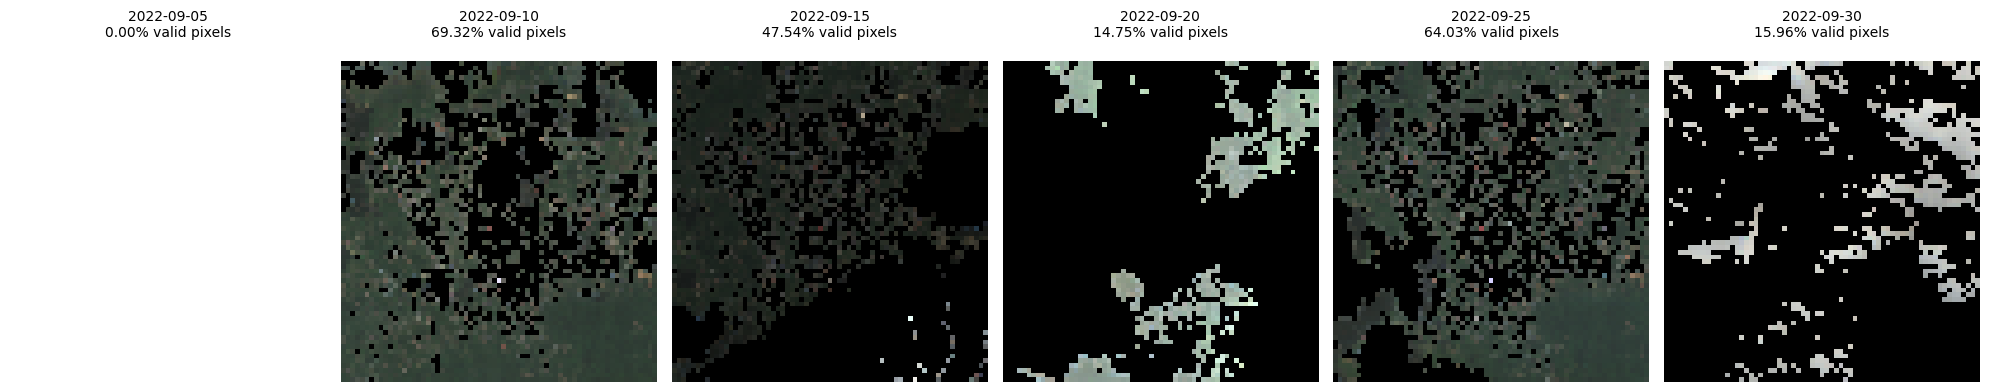

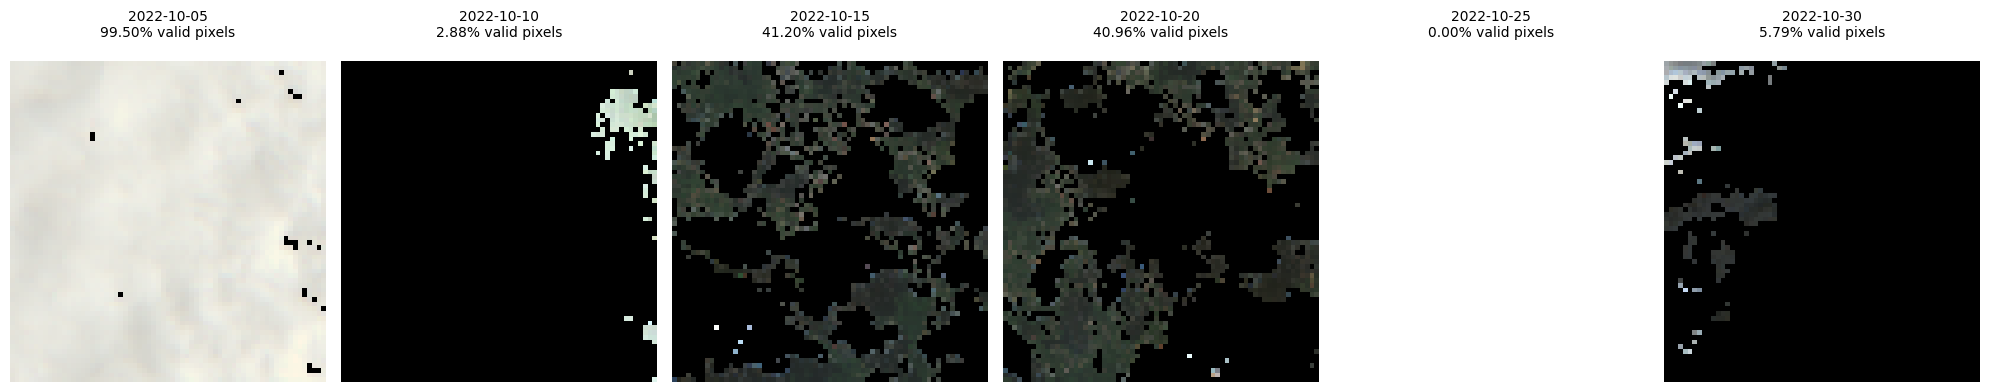

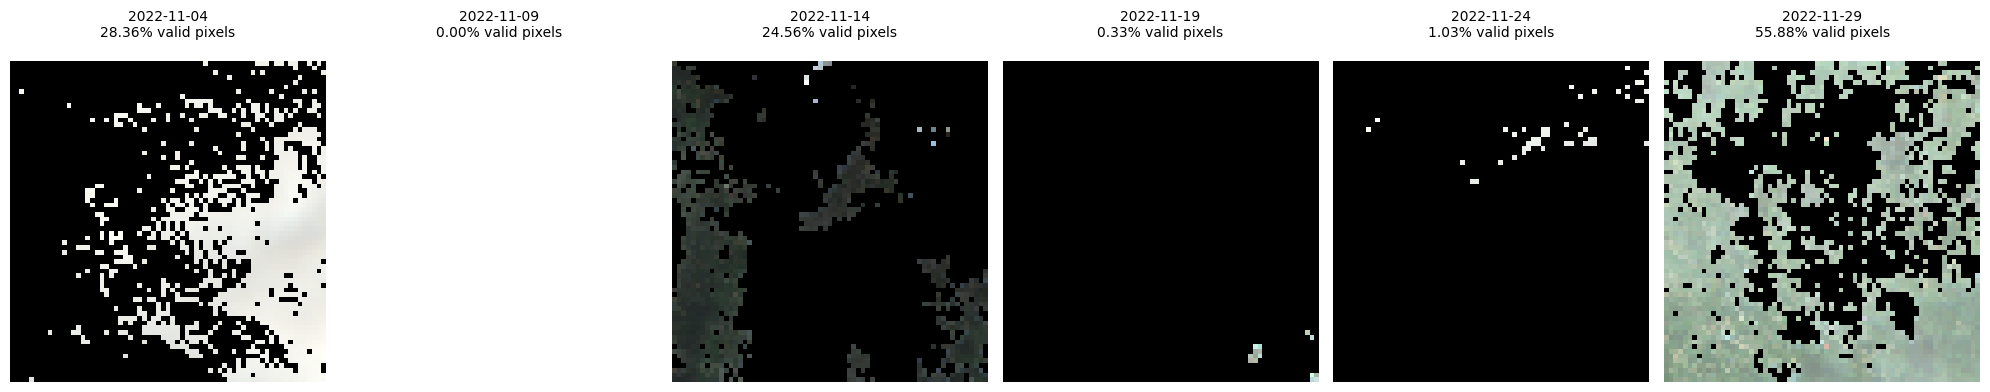

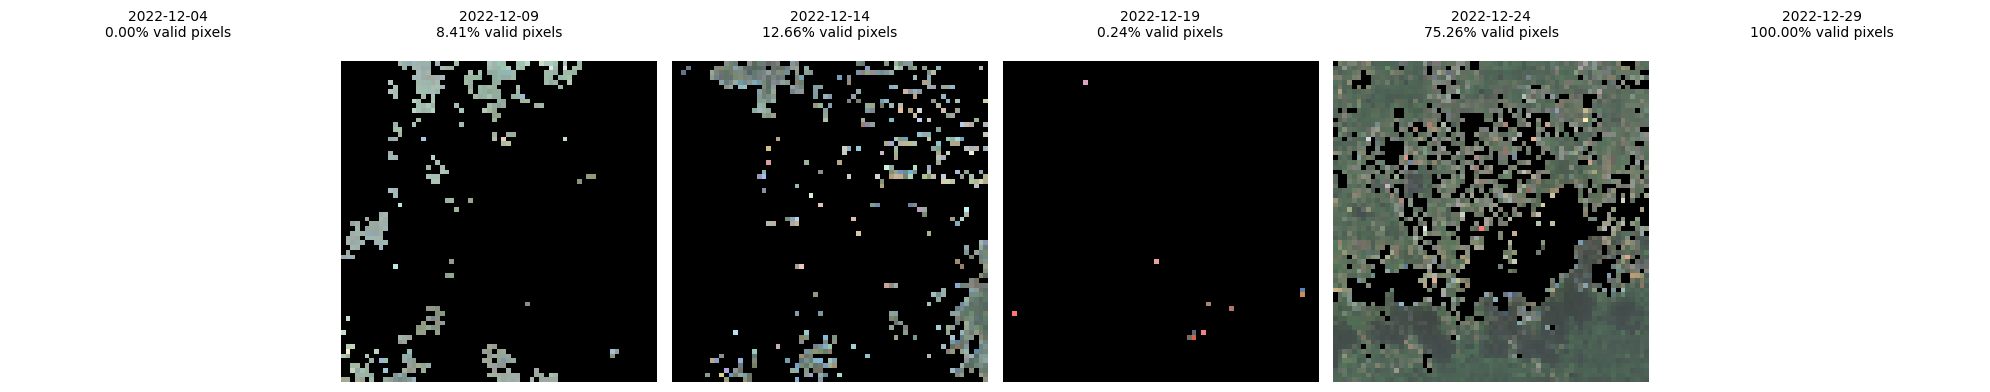

In [12]:
# Create plots for each month that has images
for month, images in images_by_month.items():
    if images:
        n_cols = min(7, len(images))  # Maximum 7 days per row
        n_rows = int(np.ceil(len(images) / n_cols))

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))

        # Ensure 'axes' is a 2D array
        axes = np.atleast_2d(axes)

        # Display the images for the month
        for idx, (day, rgb_array, date, valid_percentage, total_pixels) in enumerate(images):
            row = idx // n_cols
            col = idx % n_cols

            # Display the image in the corresponding subplot
            ax = axes[row, col]
            ax.imshow(rgb_array.transpose(1, 2, 0))  # Transpose dimensions to (height, width, bands)
            ax.axis('off')  # Hide axes for a cleaner look
            ax.set_title(f"{date.strftime('%Y-%m-%d')}\n{valid_percentage:.2f}% valid pixels\n", fontsize=10)

        plt.tight_layout()
        plt.show()

**Explanation:**

1. **Iterating Through Each Month:**
  
  - **`for month, images in images_by_month.items():`**: Loops through each month and its corresponding list of images.
  - **`if images:`**: Checks if there are any images recorded for the month.
2. **Setting Up the Plot Grid:**
  
  - **`n_cols = min(7, len(images))`**: Limits the number of columns to a maximum of 7, representing one week per row.
  - **`n_rows = int(np.ceil(len(images) / n_cols))`**: Calculates the number of rows needed based on the number of images.
  - **`plt.subplots(n_rows, n_cols, figsize=(20, 15))`**: Creates a grid of subplots with the specified number of rows and columns.
3. **Ensuring Proper Axes Format:**
  
  - **`axes = np.atleast_2d(axes)`**: Guarantees that the `axes` variable is always a 2D array, which is necessary for consistent indexing.
4. **Displaying Each Image:**
  
  - **`for idx, (day, rgb_array, date, valid_percentage, zero_pixels, total_pixels) in enumerate(images):`**: Iterates through each image and its associated statistics.
  - **`row = idx // n_cols`** and **`col = idx % n_cols`**: Calculate the row and column positions for the current subplot.
  - **`ax.imshow(rgb_array.transpose(1, 2, 0))`**: Displays the RGB image. The `transpose` function rearranges the array dimensions to match the (height, width, bands) format required by `imshow`.
  - **`ax.axis('off')`**: Hides the axis ticks and labels for a cleaner visualization.
  - **`ax.set_title(...)`**: Adds a title to each subplot, indicating the date, the percentage of valid pixels, and the count of zero-valued pixels.
5. **Finalizing the Plot:**
  
  - **`plt.tight_layout()`**: Adjusts subplot parameters to ensure that the subplots fit neatly within the figure area without overlapping.
  - **`plt.show()`**: Renders the plot.

---

### Summary

In this section, we successfully:

- **Defined the temporal and spatial parameters** for our analysis.
- **Loaded and processed Sentinel-2 datasets** by applying masks to filter out unwanted pixels such as clouds and shadows.
- **Calculated essential statistics** like the percentage of valid pixels and the count of problematic pixels.
- **Organized the processed images** by month and day for structured visualization.
- **Generated comprehensive visualizations** that display the RGB composites along with relevant metadata, facilitating an intuitive understanding of the data quality and coverage over time.

This workflow demonstrates how to effectively manage and analyze large volumes of satellite imagery data using the Open Data Cube, enabling robust geospatial analyses and informed decision-making.

---